In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from dadmm_experiment import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_nodes'] = 6
problem_spec['vector_size'] = 100
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()


problem_data['rho'] = 1.
problem_data['itr_num'] = 1000

{'n_nodes': 6, 'vector_size': 100}


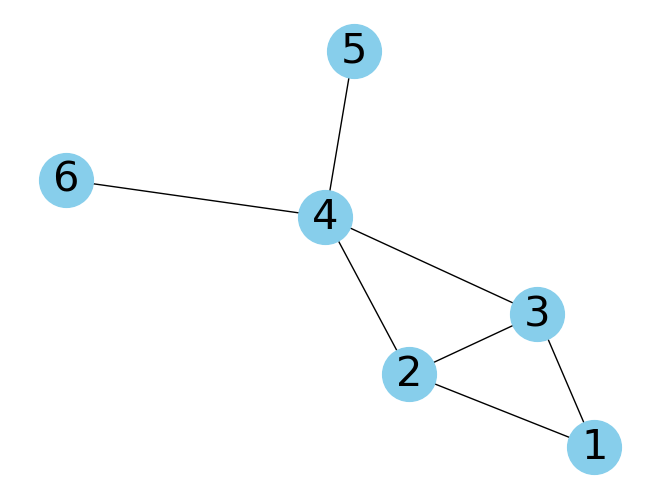

In [3]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True, font_size=30, node_size=1500)
# plt.savefig("plots/graph_n6.pdf")

In [4]:
f_star, x_opt_star = cvx_geom_median(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=6068436.1913416535, np.linalg.norm(x_opt_star)=1313.697371889053


In [5]:
b = problem_data['b']
P = problem_data['P']
 
vector_size = problem_spec['vector_size']
n_nodes = problem_spec['n_nodes']
prox_operators = []
fi_operators = []

for jj in range(n_nodes):
    bj = b[jj*vector_size : (jj+1)*vector_size]
    Pj = P[jj]
    if jj in [3, 4]:
        prox_operators += [lambda z, rho, bj=bj, Pj=Pj:  prox_fj_geom_mean_sc(z, rho, bj, Pj)]
        fi_operators += [lambda x_kj, bj=bj, Pj=Pj: 0.5 * (x_kj - bj).T @ Pj @ (x_kj - bj)]
    else:
        prox_operators += [lambda z, rho, bj=bj:  prox_fj_geom_mean(z, rho, bj)]
        fi_operators += [lambda x_kj, bj=bj: np.linalg.norm((x_kj - bj), ord=2)]

    # Testing the validity of proximals
    z = np.random.randn(vector_size)
    a = 1
    x1 = prox_fj_geom_mean(z, a, bj)
    x2 = cvx_prox_fj_geom_mean(z, a, bj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

    x1 = prox_fj_geom_mean_sc(z, a, bj, Pj)
    x2 = cvx_prox_fj_geom_mean_sc(z, a, bj, Pj, vector_size)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5, print(jj, np.linalg.norm(x1 - x2) / np.linalg.norm(x1))

In [14]:
def dadmm_optimization_func(param):
    R = param
    admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, network_data, x_opt_star, f_star, prox_operators=prox_operators,
                              fi_operators=fi_operators, params={"R":R}, printing=False)[-1]
    return admm_f_reldiff

dadmm_R = co.grid_search(dadmm_optimization_func, [0.001, 0.01, 0.1, 1, 10, 100, 1000])

new param=0.001, new new_val=0.18331719484632802
new param=0.01, new new_val=0.004871367745845695
new param=0.1, new new_val=0.00069912548830026
best_param = 0.1


In [15]:
R = dadmm_R
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.8259284039661051, err_opt_reldiff[-1]=0.9701776252256625
ii=200, f_reldiff[-1]=1.356744765382842e-09, err_opt_reldiff[-1]=0.0001043578953098825
ii=400, f_reldiff[-1]=1.9243713166632665e-09, err_opt_reldiff[-1]=3.1536197251287097e-06
ii=600, f_reldiff[-1]=1.330676513824505e-11, err_opt_reldiff[-1]=3.1532977726397385e-06
ii=800, f_reldiff[-1]=1.4283754814508146e-11, err_opt_reldiff[-1]=3.1532976108610835e-06
ii=999, f_reldiff[-1]=1.4282987464778125e-11, err_opt_reldiff[-1]=3.15329761101341e-06


In [16]:
def pg_optimization_func(param):
    problem_data['rho'] = param
    pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, network_data, x_opt_star, f_star, printing=False)[-1]
    return pg_f_reldiff

pg_rho = co.grid_search(pg_optimization_func, [0.001, 0.01, 0.05, 0.02, 0.1, 0.5, 1, 5, 10, 100, 1000])

new param=0.001, new new_val=0.06251844120885335
new param=0.01, new new_val=0.001953299395003245
best_param = 0.01


In [17]:
# apply P-EXTRA 
problem_data['rho'] = pg_rho
pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_dgeom_median(None, problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.6925050167609332, err_opt_reldiff[-1]=0.798492984030613
ii=200, f_reldiff[-1]=0.00020440383436934372, err_opt_reldiff[-1]=0.003834664795416853
ii=400, f_reldiff[-1]=2.96415161189468e-06, err_opt_reldiff[-1]=6.539221617670275e-05
ii=600, f_reldiff[-1]=2.9559671497611315e-08, err_opt_reldiff[-1]=2.212089244567794e-06
ii=800, f_reldiff[-1]=4.742380940275365e-10, err_opt_reldiff[-1]=2.241777901491916e-06
ii=999, f_reldiff[-1]=4.316495701315714e-12, err_opt_reldiff[-1]=2.2483552367229297e-06


In [18]:
params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.51541700023903}
# params={"R":0.8, "Inductance":2, "Capacitance":15, "h":3.5180363325273216}
dadmm_c_err_opt_star, dadmm_c_err_opt_reldiff, dadmm_c_const_vio, dadmm_c_f_reldiff = co.dadmm("cir_dadmm_c", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params=params, printing=True, freq=200)

ii=0, f_reldiff[-1]=0.9801228177447543, err_opt_reldiff[-1]=1.017295837957955
ii=200, f_reldiff[-1]=0.0640291828615202, err_opt_reldiff[-1]=0.050780623286819024
ii=400, f_reldiff[-1]=0.007265325148617506, err_opt_reldiff[-1]=0.006719049430619849
ii=600, f_reldiff[-1]=0.000956463954655614, err_opt_reldiff[-1]=0.0009436678478127392
ii=800, f_reldiff[-1]=0.0001316098880259082, err_opt_reldiff[-1]=0.00013596373171200765
ii=999, f_reldiff[-1]=1.8731119416027913e-05, err_opt_reldiff[-1]=2.0004646794986307e-05


In [19]:
fname = "n6_circuit_dadmm_c"

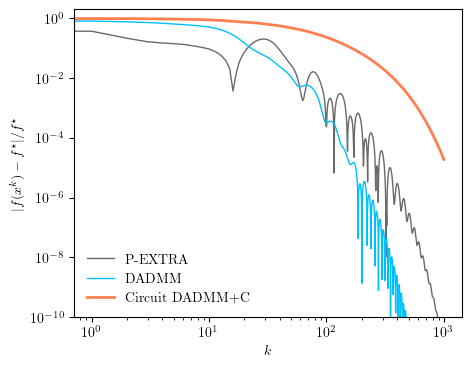

In [20]:
T = 1000
co.plot_methods([pg_f_reldiff[:T] ,admm_f_reldiff[:T], dadmm_c_f_reldiff[:T]],
                ['P-EXTRA', 'DADMM','Circuit DADMM+C'], 1e-10, 2e-0, fname)

In [21]:
np.where(np.array(dadmm_c_f_reldiff) < 1e-10)[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
np.where(np.array(admm_f_reldiff) < 1e-10)[0][0]

In [ ]:
np.where(np.array(pg_f_reldiff) < 1e-10)[0][0]